# Bayesian Updates

See https://hackmd.io/Zll9Oj4nRACweHEBkHzFzA

### Text following is not correct
To simulate training loop and importance selection as written in the paper, we consider the following. For joint angle X we divide the range $0\ldots 2\pi$ into uneven bins. We equally space $0\ldots \pi$ using $k-1$ bins and use a single bin for $\pi \ldots 2\pi$. We set the concentration parameters initially to uniform over all $k$ bins. The simulated training loop simple runs an uncertainty estimate of samples received in range $0\ldots 2\pi$ using $p$ bins. The uncertainty $u_i$ associated with each bin $i$ is inversively proportional to the number of samples seen in that bin. A sample is selected with propability $u_i$ to be part of what the paper calls candidate set $S$ (from which the control block computes updates for the simulator).

What we'd like to see in this scenarious is that the $P(\textbf{p}|X_0 \ldots X_n)$ shifts from uniform to distribution with more mass on bin $k$.


In [102]:
from scipy.stats import dirichlet
from scipy.stats import multinomial
from scipy.stats import binned_statistic
import numpy as np
import matplotlib.pyplot as plt

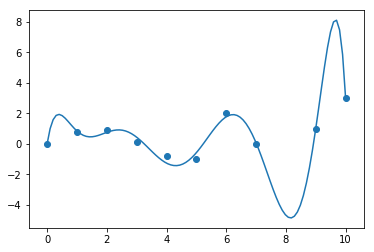

In [45]:
# ground truth poly
x = np.array([0.0, 1.0, 2.0, 3.0,  4.0,  5.0, 6.0, 7.0, 9.0, 10.0])
y = np.array([0.0, 0.8, 0.9, 0.1, -0.8, -1.0, 2.0, 0.0, 1.0, 3])
order = 8
c_star = np.polyfit(x, y, order)

xx = np.linspace(0,10,100)
yy = np.polyval(c_star, xx)
plt.plot(xx, yy)
plt.scatter(x, y)

In [122]:
bin_ranges = np.array([0., 1., 2., 3., 4., 6., 10.]) # bin ranges
nbins = bin_ranges.shape[0] - 1

h = np.array([20]*nbins) # prior concentration parameters

def generate(n, h, bin_ranges, coeffs):
    p = dirichlet.rvs(h, size=1)[0] # categorical probabilities
    c = np.random.choice(bin_ranges.shape[0] - 1, size=n, p=p) # samples from categorical
    x = [np.random.uniform(bin_ranges[i], bin_ranges[i+1]) for i in c]
    y = np.polyval(coeffs, x) + np.random.rand(len(x))
    return x, y, c, p

def fit(x, y, c, order):
    # error of new before fitting
    c_hat = np.polyfit(x[:-10], y[:-10], order)    
    e = np.abs(y[-10:] - np.polyval(c_hat, x[-10:]))
    return c_hat, (x[-10:], y[-10:], c[-10:], e)

def control(err, c, h):
    s = [cc for cc,e in zip(c,err) if e > 3]    
    e = np.zeros((len(s), nbins)) # one hot
    e[np.arange(len(s)), s] = 1    
    return h + e.sum(0) # posterior update (multinomial form)

In [134]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

hu = h.copy()
print(hu)
for i in range(200):
    xx, yy, cc, p = generate(30, hu, bin_ranges, c_star)
    _, err = fit(xx, yy, cc, order+20)
    hu = control(err[-1], err[-2], hu)
    if i % 20 == 0:
        print(hu, p)

[20 20 20 20 20 20]
[20. 20. 20. 20. 22. 20.] [0.16156512 0.20436504 0.1930503  0.15069357 0.14152703 0.14879894]
[39. 29. 25. 30. 43. 51.] [0.24489827 0.11989784 0.11160238 0.13174584 0.18282109 0.20903458]
[ 57.  36.  34.  37.  60. 104.] [0.19880305 0.14020049 0.08383922 0.11284971 0.13635035 0.32795719]
[ 78.  41.  40.  42.  70. 160.] [0.20130621 0.10463432 0.10211004 0.10996185 0.15194493 0.33004264]
[ 95.  46.  53.  50.  83. 220.] [0.16334757 0.07361215 0.11276624 0.10024731 0.16059854 0.38942818]
[104.  49.  69.  57.  96. 287.] [0.17029633 0.06296662 0.1162357  0.0898534  0.1500703  0.41057765]
[125.  56.  81.  69. 110. 339.] [0.15569256 0.07546489 0.10912519 0.08447841 0.15527404 0.41996491]
[145.  61.  86.  75. 126. 397.] [0.15812004 0.06508246 0.09496569 0.10583273 0.13986568 0.43613341]
[159.  69.  94.  85. 141. 443.] [0.16473799 0.06083967 0.11484669 0.08413133 0.11874157 0.45670275]
[180.  80. 104.  94. 155. 503.] [0.16106347 0.07578385 0.09138094 0.07588665 0.14640151 0.44

(-5, 8)

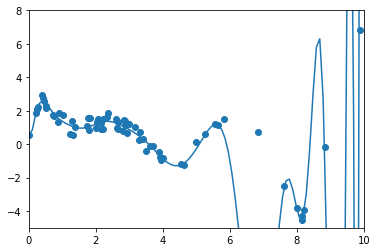

In [137]:
# Sampling at start
xx, yy, _, _ = generate(70, h, bin_ranges, c_star)
plt.scatter(xx, yy)

c_hat, e = fit(xx, yy, cc, order+20)
xxx = np.linspace(0,10,100)
yyy = np.polyval(c_hat, xxx)
plt.plot(xxx, yyy)
plt.xlim(0,10)
plt.ylim(-5,8)

(-5, 8)

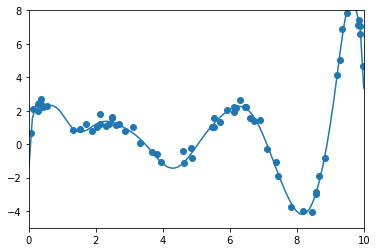

In [138]:
# Sampling with updated posterior
xx, yy, _, _ = generate(70, hu, bin_ranges, c_star)
plt.scatter(xx, yy)

c_hat, e = fit(xx, yy, cc, order+20)
xxx = np.linspace(0,10,100)
yyy = np.polyval(c_hat, xxx)
plt.plot(xxx, yyy)
plt.xlim(0,10)
plt.ylim(-5,8)